# lstm_nn_predict.ipynb

## Notebook Purpose
This notebook is designed to use the trained LSTM model to predict future cryptocurrency prices. It will load the trained LSTM model, apply it to the test data, and generate future predictions. The notebook will also visualize the predictions and compare them with the actual values.

## Instructions
1. **Import Necessary Libraries**:
   - Import `pandas` for data manipulation.
   - Import `joblib` to load the trained model.
   - Import `matplotlib` for data visualization.

2. **Load Preprocessed Data and Model**:
   - Load the preprocessed CSV file created in the data preparation notebook.
   - Load the trained LSTM model from the model generation notebook.

3. **Generate Predictions**:
   - Use the LSTM model to predict future prices.
   - Apply the model to the test data to predict prices.

4. **Visualize Predictions**:
   - Generate a plot to compare the predicted prices with the actual closing prices.

5. **Save Predictions**:
   - Save the generated predictions to a new CSV file for future reference.

## Example Code
```python
# Import necessary libraries
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load preprocessed data and model
data_path = 'data/cleaned_data/BTC_cleaned.csv'  # Update this path based on the selected cryptocurrency
data = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')
model_path = 'models/trained_lstm_model.h5'
model = load_model(model_path)

# Prepare data for prediction
X_test = data['Close'].values.reshape(-1, 1)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions if necessary
predictions = scaler.inverse_transform(predictions)

# Save predictions
results = data[['Close']].copy()
results['Predictions'] = predictions
results.to_csv('results/lstm_predictions.csv')

# Display predictions
results.head()

# Plot predictions vs actual prices
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Close'], label='Actual Price')
plt.plot(results.index, results['Predictions'], label='Predicted Price')
plt.title('LSTM Model Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

print("Libraries imported successfully.")


Libraries imported successfully.


In [2]:
# Cell 2: Load preprocessed data and model
cryptos = ['BTC', 'ETH', 'SOL']
crypto_data_paths = {
    'BTC': '../data/cleaned_data/BTC_cleaned.csv',
    'ETH': '../data/cleaned_data/ETH_cleaned.csv',
    'SOL': '../data/cleaned_data/SOL_cleaned.csv'
}
crypto_model_paths = {
    'BTC': '../models/BTC_lstm_model.h5',
    'ETH': '../models/ETH_lstm_model.h5',
    'SOL': '../models/SOL_lstm_model.h5'
}

crypto_data = {}
crypto_models = {}

try:
    for crypto in cryptos:
        # Load data
        data_path = crypto_data_paths[crypto]
        prices_df = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')
        crypto_data[crypto] = prices_df
        print(f"{crypto} data loaded successfully.")
        
        # Load model
        model_path = crypto_model_paths[crypto]
        if os.path.exists(model_path):
            model = load_model(model_path)
            crypto_models[crypto] = model
            print(f"{crypto} model loaded successfully.")
        else:
            print(f"Model file for {crypto} not found: {model_path}")
except Exception as e:
    print(f"Error loading data or model: {e}")


BTC data loaded successfully.
BTC model loaded successfully.
ETH data loaded successfully.
ETH model loaded successfully.
SOL data loaded successfully.
SOL model loaded successfully.


In [3]:
# Cell 3: Function to create sequences of data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length), 0]
        y = data[i+seq_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


In [4]:
# Cell 4: Prepare data for prediction
crypto_prepared_data = {}
crypto_scalers = {}

try:
    for crypto, prices_df in crypto_data.items():
        close = prices_df['Close'].values.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_close = scaler.fit_transform(close)

        seq_length = 60
        X, y = create_sequences(scaled_close, seq_length)

        split = int(len(X) * 0.80)
        X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        crypto_prepared_data[crypto] = (X_test, y_test)
        crypto_scalers[crypto] = scaler
        print(f"Data prepared for prediction for {crypto}.")
except Exception as e:
    print(f"Error preparing data for prediction: {e}")


Data prepared for prediction for BTC.
Data prepared for prediction for ETH.
Data prepared for prediction for SOL.


In [5]:
# Cell 5: Generate predictions using the trained LSTM model
crypto_predictions = {}

try:
    for crypto, (X_test, y_test) in crypto_prepared_data.items():
        if crypto in crypto_models:
            model = crypto_models[crypto]
            y_pred = model.predict(X_test)
            y_pred = crypto_scalers[crypto].inverse_transform(y_pred)
            y_test_inv = crypto_scalers[crypto].inverse_transform(y_test.reshape(-1, 1))
            
            crypto_predictions[crypto] = (y_pred, y_test_inv)
            print(f"Predictions generated for {crypto}.")
        else:
            print(f"Skipping predictions for {crypto} due to missing model.")
except Exception as e:
    print(f"Error generating predictions: {e}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predictions generated for BTC.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predictions generated for ETH.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predictions generated for SOL.


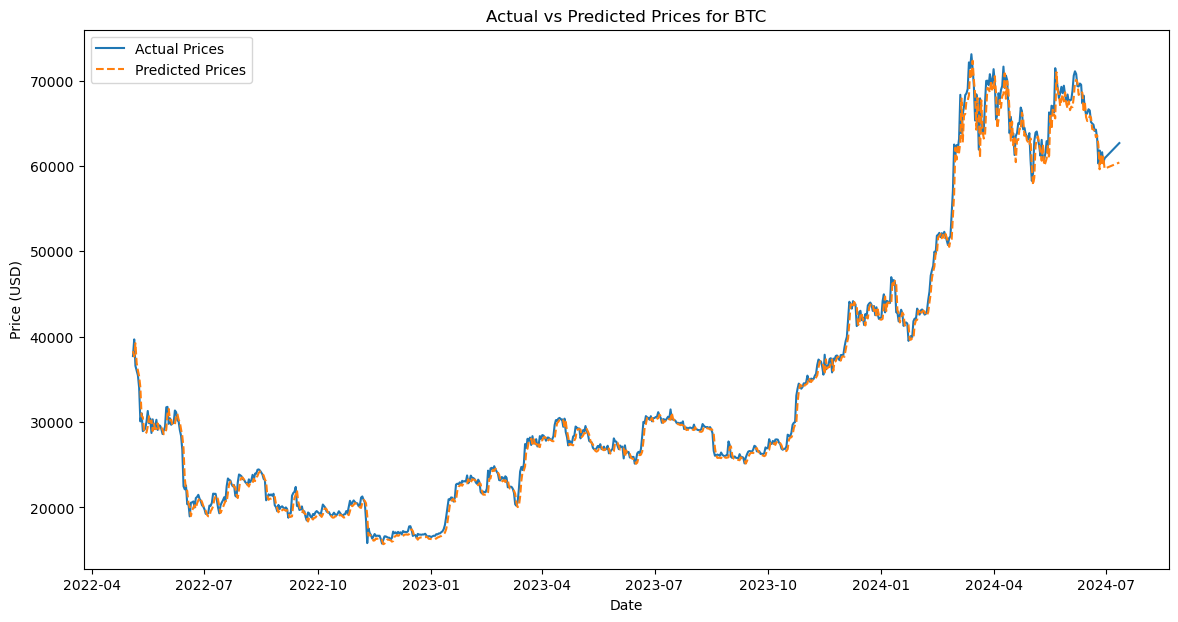

Comparison plot generated for BTC.


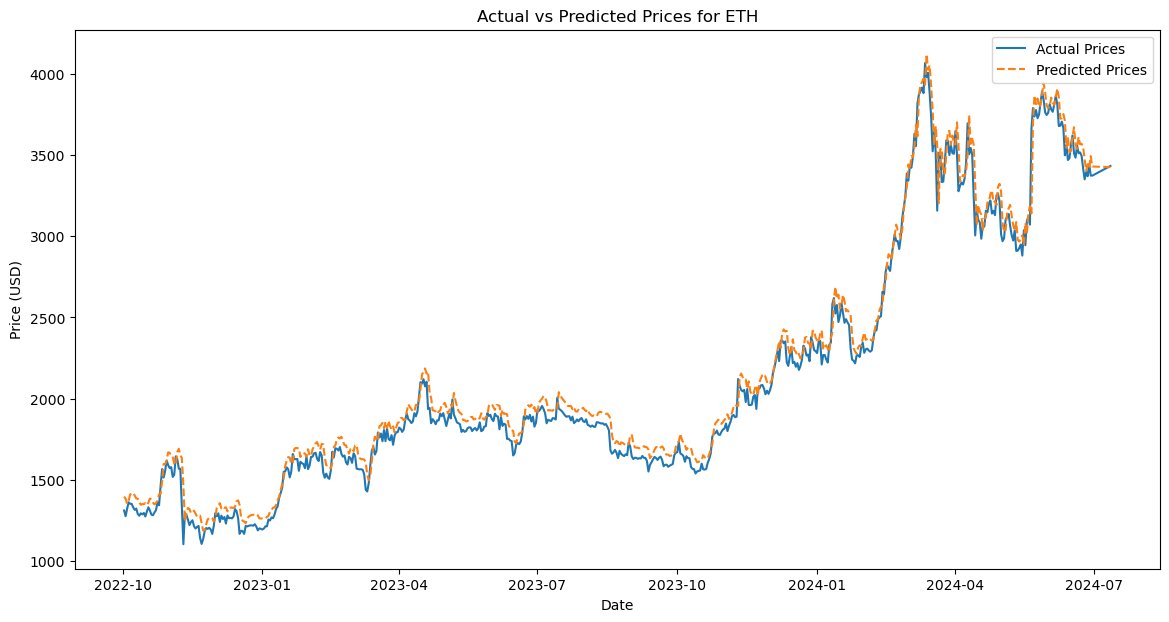

Comparison plot generated for ETH.


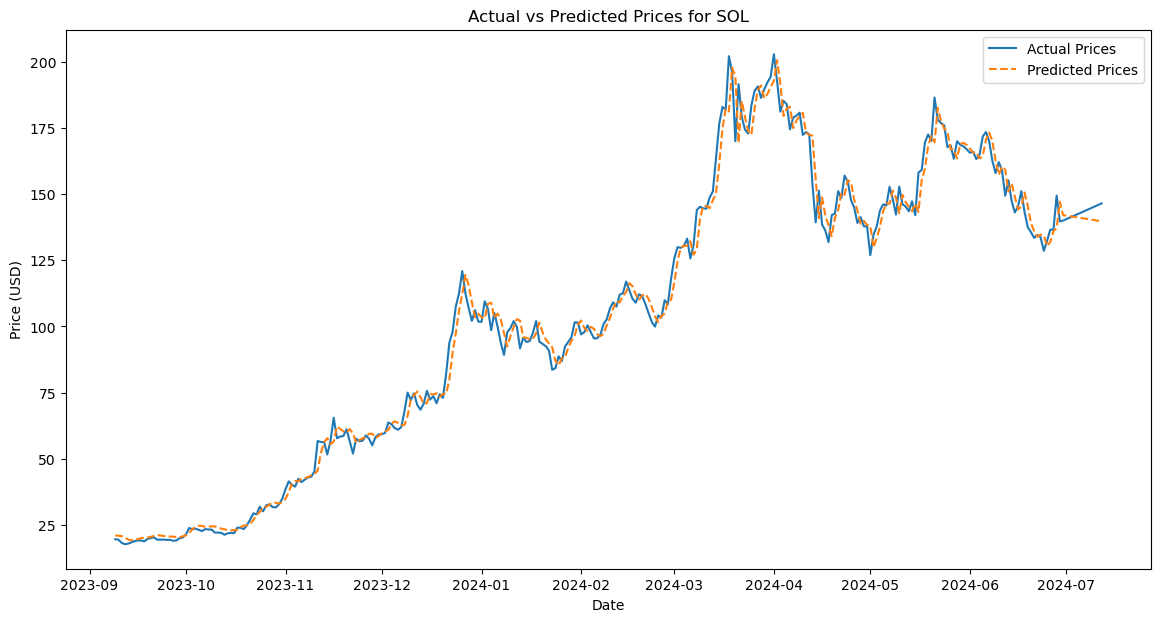

Comparison plot generated for SOL.


In [6]:
# Cell 6: Compare predictions vs actual values
try:
    for crypto, (y_pred, y_test_inv) in crypto_predictions.items():
        prices_df = crypto_data[crypto]
        plt.figure(figsize=(14, 7))
        plt.plot(prices_df.index[-len(y_test_inv):], y_test_inv, label='Actual Prices')
        plt.plot(prices_df.index[-len(y_test_inv):], y_pred, label='Predicted Prices', linestyle='--')
        plt.title(f'Actual vs Predicted Prices for {crypto}')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.show()
        print(f"Comparison plot generated for {crypto}.")
except Exception as e:
    print(f"Error comparing predictions vs actual values: {e}")


In [7]:
# Cell 7: Predict future prices
crypto_future_predictions = {}

try:
    for crypto, scaler in crypto_scalers.items():
        if crypto in crypto_models:
            prices_df = crypto_data[crypto]
            scaled_close = scaler.transform(prices_df['Close'].values.reshape(-1, 1))

            X_future = []
            start_index = len(scaled_close) - seq_length
            for i in range(start_index, start_index + 30):
                seq = scaled_close[i - seq_length:i, 0]
                X_future.append(seq)

            X_future = np.array(X_future)
            X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

            nn_future_predictions = crypto_models[crypto].predict(X_future)
            nn_future_predictions = scaler.inverse_transform(nn_future_predictions)
            
            crypto_future_predictions[crypto] = nn_future_predictions
            print(f"Future predictions generated for {crypto}.")
        else:
            print(f"Skipping future predictions for {crypto} due to missing model.")
except Exception as e:
    print(f"Error predicting future prices: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Future predictions generated for BTC.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Future predictions generated for ETH.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Future predictions generated for SOL.


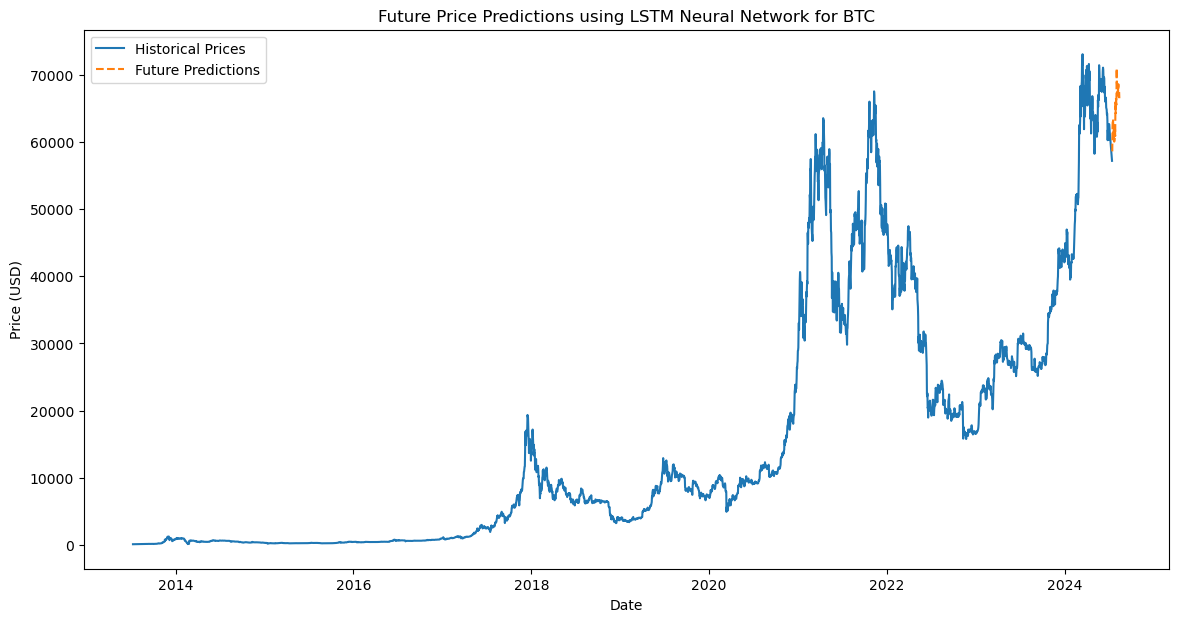

Future predictions plot generated for BTC.


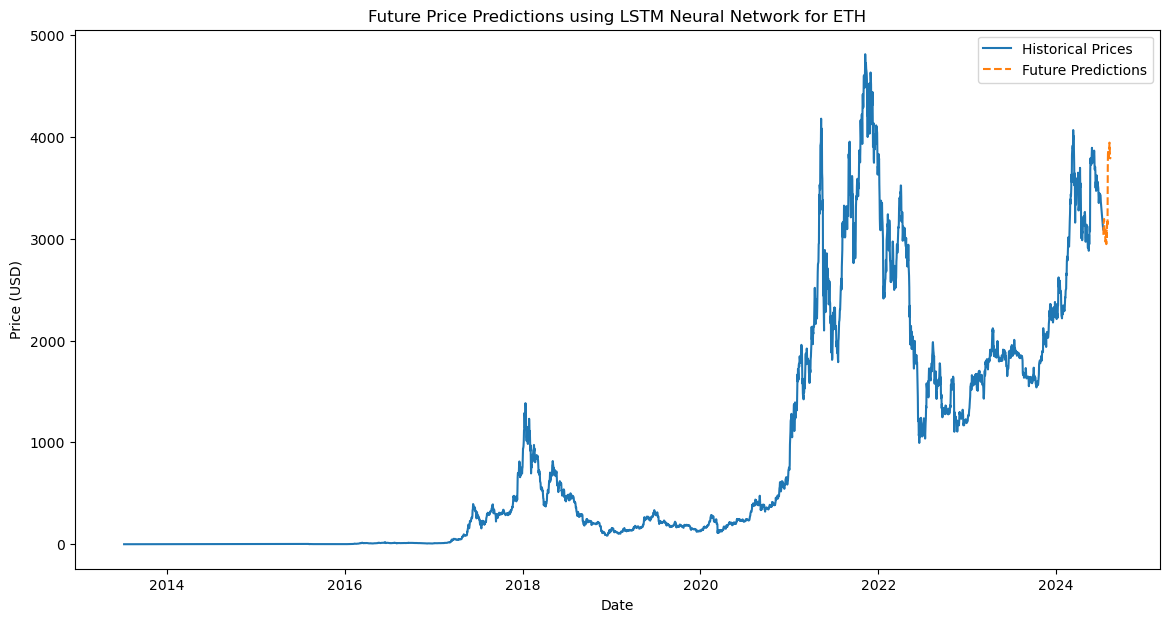

Future predictions plot generated for ETH.


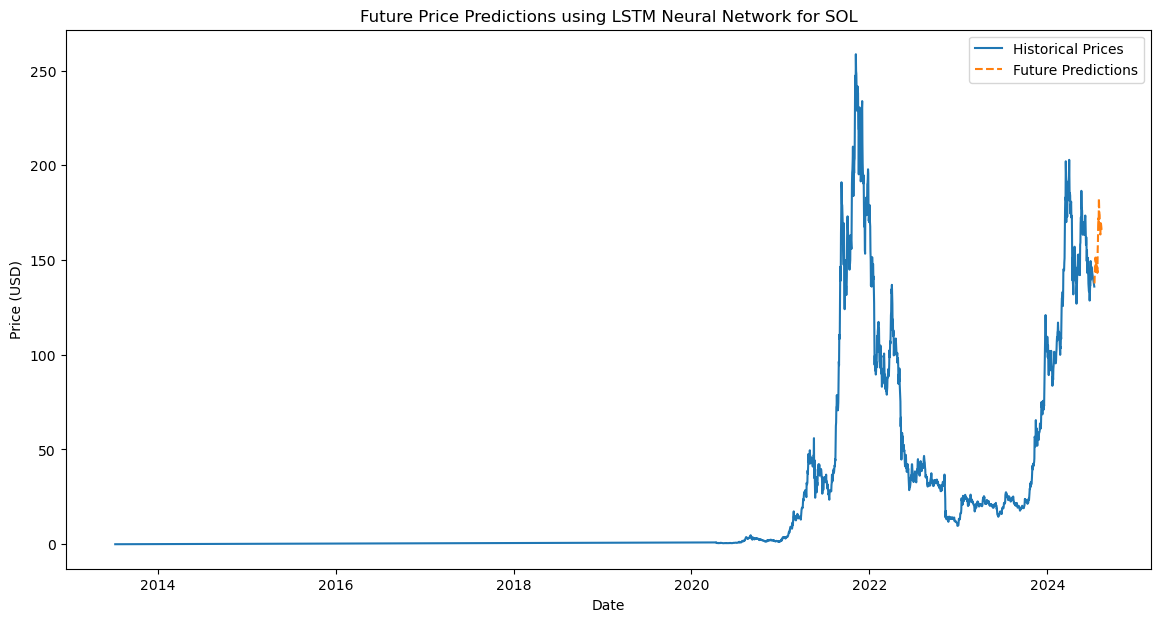

Future predictions plot generated for SOL.


In [8]:
# Cell 8: Plot future predictions
try:
    for crypto, nn_future_predictions in crypto_future_predictions.items():
        prices_df = crypto_data[crypto]
        last_date = prices_df.index[-1]
        next_30_days = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

        plt.figure(figsize=(14, 7))
        plt.plot(prices_df['Close'], label='Historical Prices')
        plt.plot(next_30_days, nn_future_predictions, label='Future Predictions', linestyle='--')
        plt.title(f'Future Price Predictions using LSTM Neural Network for {crypto}')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.show()
        print(f"Future predictions plot generated for {crypto}.")
except Exception as e:
    print(f"Error plotting future predictions: {e}")


In [9]:
# Cell 9: Save the future predictions
try:
    for crypto, nn_future_predictions in crypto_future_predictions.items():
        last_date = crypto_data[crypto].index[-1]
        next_30_days = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
        
        future_predictions_df = pd.DataFrame({
            'Date': next_30_days,
            'Predicted_Price': nn_future_predictions.flatten()
        })
        output_path = f'../results/output_predictions/{crypto}_future_predictions.csv'
        future_predictions_df.to_csv(output_path, index=False)
        print(f"Future predictions saved to {output_path} for {crypto}.")
except Exception as e:
    print(f"Error saving future predictions: {e}")


Future predictions saved to ../results/output_predictions/BTC_future_predictions.csv for BTC.
Future predictions saved to ../results/output_predictions/ETH_future_predictions.csv for ETH.
Future predictions saved to ../results/output_predictions/SOL_future_predictions.csv for SOL.
